# Project 2: Advanced Lane Line Detection

## Notebook 2: Pipeline Refinement
In this notebook, the pipeline class object is refined for better functionality, and attempts are then made to expand its abilities to handle the project videos. This second notebook was necessary because the first became too long to easily edit. It seems the pipeline class contains a large enough amount of code to make the editing process within a Jupyter notebook cell unwieldy, so the modification of the class object will be done in a text editor, and tested in this notebook with an autoreloaded import. Please reference lane_finder.py for the code of the class object.

#### Notes:
- Need to add averaging of lane polynomial curves over recent frames to smooth performance.
- Need to add integrity check which will cause pipeline to refit lanes if estimates go awry, as they did in the challenge video test from the last notebook.

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# Import the lane finding pipeline
from lane_finder import Lane_Finder

# Import tools for videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

pygame 2.0.0 (SDL 2.0.12, python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [8]:
%load_ext autoreload
%autoreload 1
%aimport lane_finder

In [191]:
# To demonstrate the refinement process, I will instantiate the object with the default
# parameteres defined in the last notebook, and work through edits in this notebook. The
# defaults of the class object in the .py file will change accordingly.
lanefinder = Lane_Finder(mtx=None, 
                         dist=None, 
                         calib_dir='camera_cal/',
                         nx=9,
                         ny=6,
                         objp=None,
                         src=None,
                         dst=None,
                         s_thresh=(120, 255), 
                         sx_thresh=(20, 100),
                         frame_buffer=5,
                         margin=100,
                         padding=200,
                         lane_length=60.0,
                         lane_width=3.7,
                         nwindows=9,
                         minpix=50,
                         output_dir='output_images/'
                        )

Calibrating camera with images in camera_cal/
Corners not found for  calibration1.jpg
Corners not found for  calibration4.jpg
Corners not found for  calibration5.jpg
Calibration successful!


In [81]:
%time lanefinder.process_video('project_video.mp4', write_path='project_video_FINAL.mp4')

Moviepy - Building video output_images/project_video_FINAL.mp4.
Moviepy - Writing video output_images/project_video_FINAL.mp4



Moviepy - Done !
Moviepy - video ready output_images/project_video_FINAL.mp4
Wall time: 2min 40s


In [82]:
HTML("""
     <video width="{}" height="{}" controls>
     <source src="{}">
     </video>
     """.format(1280, 720, 'output_images/project_video_FINAL.mp4'))

In [83]:
# As a sanity check, we know from the last notebook that the base of the lane is about 1000
# pixels wide, and that the lane should be about 3.7m wide. Let's see if our meter to pixel
# conversion in the x direction is working out decently
lanefinder.xm_per_pixel * 1000

3.925571415725646

In [ ]:
# This is relatively close to 3.7m

#### Challenge Video
The pipeline worked well enough on the project video. Now let's see how it looks on the challenge video.

In [84]:
%time lanefinder.process_video('challenge_video.mp4', write_path='challenge_video_output_1.mp4')

Moviepy - Building video output_images/challenge_video_output_1.mp4.
Moviepy - Writing video output_images/challenge_video_output_1.mp4



t: 100%|██████████| 485/485 [00:52<00:00,  9.16it/s, now=None]WARNING:py.warnings:C:\ProgramData\Anaconda3\lib\site-packages\moviepy\video\io\ffmpeg_reader.py:130: UserWarning: Warning: in file challenge_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 484/485, at time 16.15/16.15 sec. Using the last valid frame instead.
  UserWarning)



Moviepy - Done !
Moviepy - video ready output_images/challenge_video_output_1.mp4
Wall time: 54.9 s


In [86]:
HTML("""
     <video width="{}" height="{}" controls>
     <source src="{}">
     </video>
     """.format(1280, 720, 'output_images/challenge_video_output_1.mp4'))

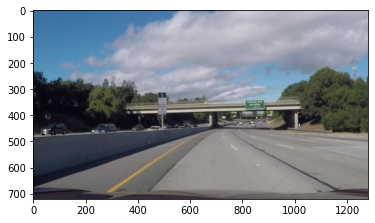

In [93]:
# We can see that the change in pavement surface running down the center of the lane is 
# throwing off the line detection. Some careful threshold adjustments may help to solve this.
# To get an idea, we need to isolate a useful from this video to work with
vidcap = cv2.VideoCapture('challenge_video.mp4')
count = 0
while count < 50:
    #print(count)
    #cv2.imshow('frame', image)
    #cv2.waitKey(0)
    success, image = vidcap.read()
    count+=1
    
# Reverse RGB channels
image = image[:, :, ::-1]
plt.imshow(image);

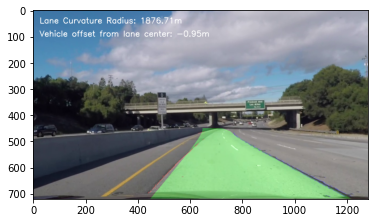

In [94]:
# Run the pipeline on this image
output = lanefinder.process_image(image)
plt.imshow(output);

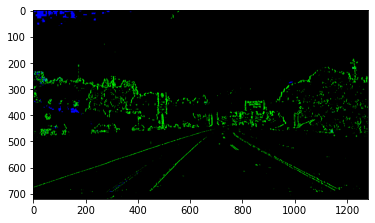

In [151]:
# Let's see the binary image being produced to diagnose the issue
output = lanefinder.binary_lane_img(image, diagnostic=True)
plt.imshow(output);

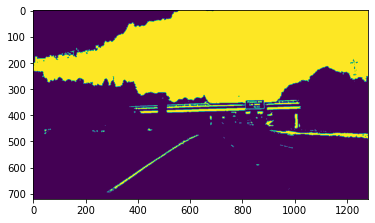

In [202]:
# We can see that the lane lines are being detected less than the changes in pavement
# The green color indicates that it is being detected by the x gradient. The blue is 
# associated with saturation, and it is not playing a role here
# I will first try adding lightness thresholding
output = lanefinder.binary_lane_img(image, 
                                    h_thresh=(0, 255),
                                    l_thresh=(130, 255),
                                    s_thresh=(15, 255),
                                    sx_thresh=(0, 255), 
                                    diagnostic=False)
plt.imshow(output);

In [204]:
# These thresholds seem to be filtering out the dark lines in the pavement, by adding the 
# condition that the pixels must be above a certain lightness threshold. I also changed
# the saturation thresholds. Let's see how these parameters affect the challenge video
lanefinder.h_thresh=(0, 255)
lanefinder.l_thresh=(130, 255)
lanefinder.s_thresh=(15, 255)
lanefinder.sx_thresh=(0, 255) 

%time lanefinder.process_video('challenge_video.mp4', write_path='challenge_video_output_2.mp4')

Moviepy - Building video output_images/challenge_video_output_2.mp4.


Moviepy - Writing video output_images/challenge_video_output_2.mp4



t:  27%|██▋       | 130/485 [00:15<00:41,  8.65it/s, now=None]


t:  54%|█████▎    | 260/485 [00:32<00:27,  8.12it/s, now=None]


t:  80%|████████  | 390/485 [00:49<00:13,  7.22it/s, now=None]


t: 100%|██████████| 485/485 [01:02<00:00,  6.67it/s, now=None]


Moviepy - Done !


Moviepy - video ready output_images/challenge_video_output_2.mp4


t:   6%|▌         | 30/485 [01:57<00:49,  9.27it/s, now=None]

Wall time: 1min 4s


In [205]:
HTML("""
     <video width="{}" height="{}" controls>
     <source src="{}">
     </video>
     """.format(1280, 720, 'output_images/challenge_video_output_2.mp4'))